In [16]:
import torch
from torch import nn
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tqdm


device = "cuda" if torch.cuda.is_available() else "cpu"

# Binary Classifier

## Data preparation/loading

In [4]:
X,Y = make_circles(n_samples=1000,noise=0.05,random_state=42)
X.shape,Y.shape,type(X),type(Y),X[:5],Y[:5]

((1000, 2),
 (1000,),
 numpy.ndarray,
 numpy.ndarray,
 array([[ 0.74220688,  0.24668576],
        [-0.7340323 ,  0.16869164],
        [-0.82985872,  0.22195899],
        [-0.42913559,  0.67223019],
        [ 0.44560223, -0.89493556]]),
 array([1, 1, 1, 1, 0]))

In [5]:
# convert ndarry to torch tensors
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)
X.shape,Y.shape,type(X),type(Y),X[:5],Y[:5]

(torch.Size([1000, 2]),
 torch.Size([1000]),
 torch.Tensor,
 torch.Tensor,
 tensor([[ 0.7422,  0.2467],
         [-0.7340,  0.1687],
         [-0.8299,  0.2220],
         [-0.4291,  0.6722],
         [ 0.4456, -0.8949]]),
 tensor([1., 1., 1., 1., 0.]))

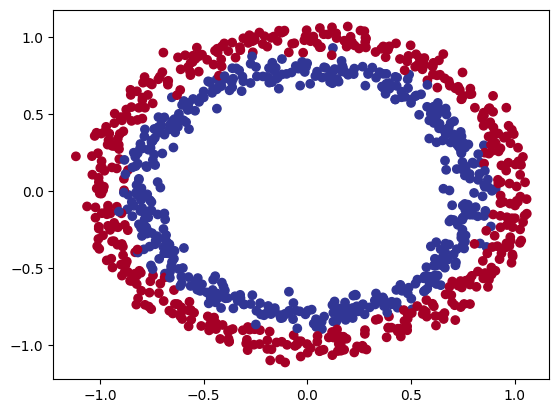

In [6]:
# visualize
_ = plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, cmap=plt.cm.RdYlBu)

In [14]:
# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
len(X_train),type(X_train),X_train.shape

(800, torch.Tensor, torch.Size([800, 2]))

## Build model

In [8]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
    
    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [11]:
# more settings
model = BinaryClassifier().to(device)
print(model)
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
loss_fn = nn.BCEWithLogitsLoss()
EPOCHS = 1000
def accuracy_fn(y_true,y_pred):
    return (torch.eq(y_true, y_pred).sum() / len(y_pred)) * 100

BinaryClassifier(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


## Train the model

In [13]:
torch.manual_seed(42)

epochs_list = []
training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

for epoch in range(EPOCHS):
    epochs_list.append(epoch)

    # train
    model.train()
    Y_train_logits = model(X_train.to(device)).squeeze()
    training_loss = loss_fn(Y_train_logits,Y_train)
    Y_train_pred = torch.round(torch.sigmoid(Y_train_logits)) # convert probabilities to labels if ~50%, say 1
    training_acc = accuracy_fn(Y_train,Y_train_pred.squeeze())
    optimizer.zero_grad()
    training_loss.backward()
    optimizer.step()
    
    training_losses.append(training_loss.item())
    training_accuracies.append(training_acc.item())


    #test
    model.eval()
    with torch.inference_mode():
        Y_test_logits = model(X_test.to(device)).squeeze()
        testing_loss = loss_fn(Y_test_logits,Y_test)
        
        Y_test_pred = torch.round(torch.sigmoid(Y_test_logits))
        testing_acc = accuracy_fn(Y_test,Y_test_pred.squeeze())

        testing_losses.append(testing_loss.item())
        testing_accuracies.append(testing_acc.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | training loss: {training_loss:.3f}, training acc: {training_acc:.2f}% | testing loss: {testing_loss:.3f}, testing acc: {testing_acc:.2f}%")


Epoch 0 | training loss: 0.576, training acc: 84.62% | testing loss: 0.590, testing acc: 84.00%
Epoch 100 | training loss: 0.499, training acc: 90.12% | testing loss: 0.528, testing acc: 85.50%
Epoch 200 | training loss: 0.401, training acc: 93.88% | testing loss: 0.456, testing acc: 85.50%
Epoch 300 | training loss: 0.301, training acc: 96.50% | testing loss: 0.377, testing acc: 90.50%
Epoch 400 | training loss: 0.225, training acc: 97.38% | testing loss: 0.312, testing acc: 91.00%
Epoch 500 | training loss: 0.176, training acc: 97.38% | testing loss: 0.266, testing acc: 91.00%
Epoch 600 | training loss: 0.143, training acc: 97.50% | testing loss: 0.233, testing acc: 92.00%
Epoch 700 | training loss: 0.122, training acc: 97.88% | testing loss: 0.210, testing acc: 93.00%
Epoch 800 | training loss: 0.106, training acc: 98.12% | testing loss: 0.192, testing acc: 93.00%
Epoch 900 | training loss: 0.095, training acc: 98.25% | testing loss: 0.181, testing acc: 93.00%


# Multiclass classifier

## Data preparation

In [57]:
X,Y = make_blobs(n_samples=1000,n_features=2,centers=4,cluster_std=1.5,random_state=42)
X = torch.from_numpy(X).type(torch.float).to(device)
Y = torch.from_numpy(Y).type(torch.LongTensor).to(device)
X.shape,Y.shape,type(X),type(Y),X[:5],Y[:5]

(torch.Size([1000, 2]),
 torch.Size([1000]),
 torch.Tensor,
 torch.Tensor,
 tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

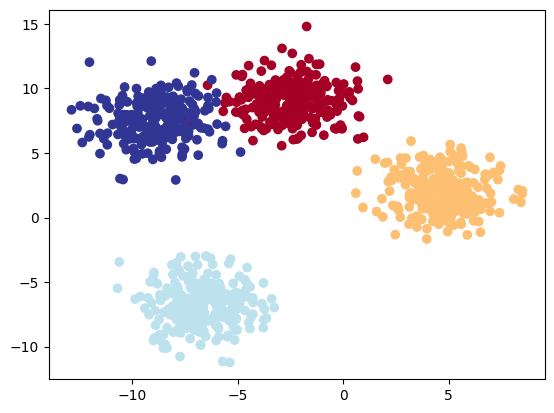

In [58]:
_ = plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, cmap=plt.cm.RdYlBu)

In [59]:
# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
len(X_train),type(X_train),X_train.shape

(800, torch.Tensor, torch.Size([800, 2]))

## Build Model

In [60]:
class MulticlassClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=4),
        )
    
    def forward(self, x):
       return self.linear_stack((x))

model = MulticlassClassifier().to(device)
print(model(X_test)[:5])
model

tensor([[ 0.2278,  0.3711,  0.8627, -0.3775],
        [-0.1974,  0.1331,  0.1715, -0.1909],
        [ 0.0566,  0.1291,  0.0878, -0.1532],
        [ 0.0073,  0.1208,  0.5334, -0.3750],
        [-0.0646,  0.5400,  0.5424, -0.4671]], grad_fn=<SliceBackward0>)


MulticlassClassifier(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [71]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
EPOCHS=300

In [74]:
torch.manual_seed(42)

epochs_list = []
training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

for epoch in range(EPOCHS):
    epochs_list.append(epoch)

    #train
    model.train()
    Y_train_logits = model(X_train)
    Y_train_pred = torch.softmax(Y_train_logits,dim=1).argmax(dim=1)
    training_loss = loss_fn(Y_train_logits,Y_train)
    training_acc = accuracy_fn(Y_train,Y_train_pred)
    optimizer.zero_grad()
    training_loss.backward()
    optimizer.step()

    training_losses.append(training_loss.item())
    training_accuracies.append(training_acc.item())


    #test
    model.eval()
    with torch.inference_mode():
        Y_test_logits = model(X_test)
        Y_test_pred = torch.softmax(Y_test_logits, dim=1).argmax(dim=1)
        testing_loss = loss_fn(Y_test_logits,Y_test)
        testing_acc = accuracy_fn(Y_test,Y_test_pred)

        testing_losses.append(testing_loss.item())
        testing_accuracies.append(testing_acc.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | training loss: {training_loss:.3f} training acc: {training_acc:.2f}% | testing loss: {testing_loss:.3f} testing acc: {testing_acc:.2f}%")


Epoch 0 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 10 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 20 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 30 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 40 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 50 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 60 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 70 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 80 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 90 | training loss: 0.025 training acc: 99.25% | testing loss: 0.014 testing acc: 99.50%
Epoch 100 | training loss: 0.025 training acc: 99.2